Импорт библиотек

In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (recall_score, precision_score, f1_score, roc_auc_score,
                             mean_absolute_error, mean_squared_error, r2_score,
                             classification_report, confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Загрузка и обработка данных для классификации

In [58]:
df_burnout = pd.read_csv('data/employee_burnout.csv')
print("Employee Burnout")

print(f"Размер: {df_burnout.shape}")


# Разделение на признаки и цель
X_clf = df_burnout.drop(['Burnout', 'Name'], axis=1)
y_clf = df_burnout['Burnout']

# Определение типов признаков
categorical_features_clf = ['Gender', 'JobRole']
numeric_features_clf = [col for col in X_clf.columns if col not in categorical_features_clf]

# Создание предобработчика
preprocessor_clf = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_clf),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features_clf)
    ])

Employee Burnout
Размер: (2000, 10)


Загрузка и обработка данных для регрессии

In [60]:
df_sales = pd.read_csv('data/walmart_sales.csv')

print("Walmart Sales")

df_sales['Date'] = pd.to_datetime(df_sales['Date'], format='%d-%m-%Y')
df_sales = df_sales.sort_values('Date')
print(f"Размер: {df_sales.shape}")

X_reg = df_sales.drop(['Weekly_Sales', 'Date'], axis=1)
y_reg = df_sales['Weekly_Sales']

categorical_features_reg = ['Store', 'Holiday_Flag']
numeric_features_reg = [col for col in X_reg.columns if col not in categorical_features_reg]

preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_reg),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features_reg)
    ])


Walmart Sales
Размер: (6435, 8)


Обучение бейзлайновых моделей

In [64]:


logreg_clf = Pipeline([
    ('preprocessor', preprocessor_clf),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
])

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.3, random_state=42, stratify=y_clf
)

print("\nОбучение LogisticRegression для классификации...")
logreg_clf.fit(X_train_clf, y_train_clf)
print("LogisticRegression обучен")

linreg_reg = Pipeline([
    ('preprocessor', preprocessor_reg),
    ('regressor', LinearRegression())
])

split_idx = int(len(df_sales) * 0.7)
X_train_reg, X_test_reg = X_reg.iloc[:split_idx], X_reg.iloc[split_idx:]
y_train_reg, y_test_reg = y_reg.iloc[:split_idx], y_reg.iloc[split_idx:]

print("\nОбучение LinearRegression для регрессии...")
linreg_reg.fit(X_train_reg, y_train_reg)
print("LinearRegression обучен")



Обучение LogisticRegression для классификации...
LogisticRegression обучен

Обучение LinearRegression для регрессии...
LinearRegression обучен


Оценка качества модели классификации


In [66]:

y_pred_clf = logreg_clf.predict(X_test_clf)
y_proba_clf = logreg_clf.predict_proba(X_test_clf)[:, 1]

clf_recall = recall_score(y_test_clf, y_pred_clf)
clf_precision = precision_score(y_test_clf, y_pred_clf)
clf_f1 = f1_score(y_test_clf, y_pred_clf, average='weighted')
clf_rocauc = roc_auc_score(y_test_clf, y_proba_clf)

print(f"Recall (класс 1): {clf_recall:.4f}")
print(f"Precision (класс 1): {clf_precision:.4f}")
print(f"F1-score (weighted): {clf_f1:.4f}")
print(f"ROC-AUC: {clf_rocauc:.4f}")

print("\nМатрица ошибок:")
print(confusion_matrix(y_test_clf, y_pred_clf))

print("\nДетальный отчет:")
print(classification_report(y_test_clf, y_pred_clf))

Recall (класс 1): 1.0000
Precision (класс 1): 0.4333
F1-score (weighted): 0.9298
ROC-AUC: 0.9871

Матрица ошибок:
[[510  51]
 [  0  39]]

Детальный отчет:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       561
           1       0.43      1.00      0.60        39

    accuracy                           0.92       600
   macro avg       0.72      0.95      0.78       600
weighted avg       0.96      0.92      0.93       600



Оценка качества модели регрессии

In [76]:
y_pred_reg = linreg_reg.predict(X_test_reg)

reg_mae = mean_absolute_error(y_test_reg, y_pred_reg)
reg_rmse = root_mean_squared_error(y_test_reg, y_pred_reg)
reg_r2 = r2_score(y_test_reg, y_pred_reg)

print(f"MAE: ${reg_mae:,.2f}")
print(f"RMSE: ${reg_rmse:,.2f}")
print(f"R²: {reg_r2:.4f}")

errors = np.abs(y_test_reg - y_pred_reg)
print(f"Средняя относительная ошибка: {errors.mean() / y_test_reg.mean() * 100:.2f}%")
print(f"90-й перцентиль ошибки: ${np.percentile(errors, 90):,.2f}")

MAE: $139,864.65
RMSE: $172,597.35
R²: 0.8967
Средняя относительная ошибка: 13.53%
90-й перцентиль ошибки: $264,305.95


Визуализация результатов

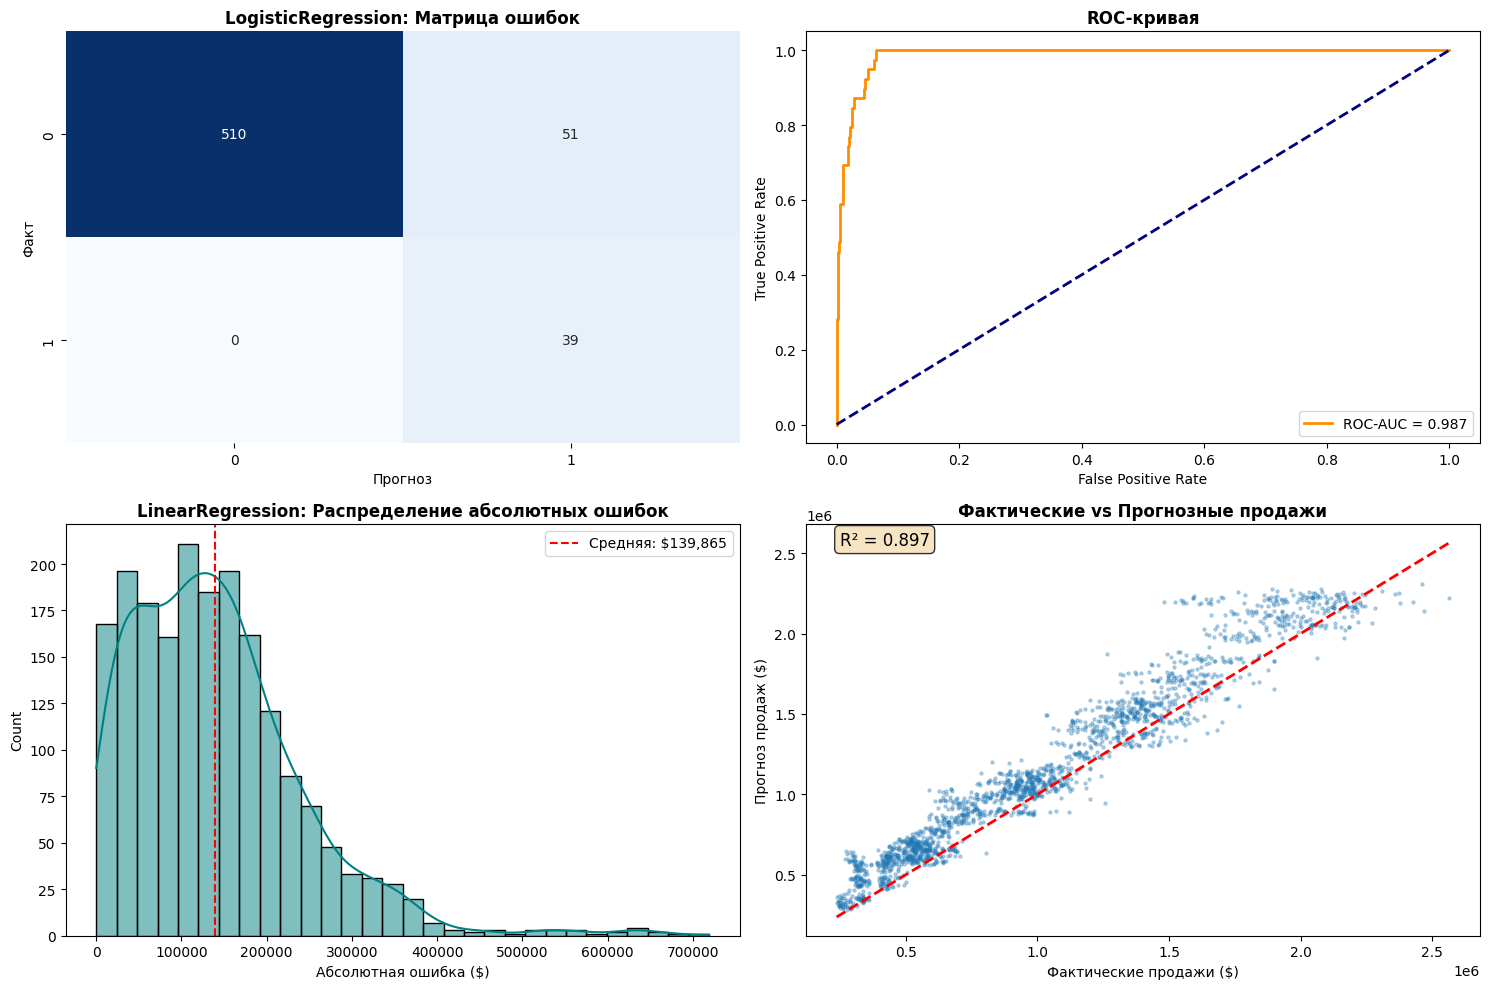

In [77]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

cm = confusion_matrix(y_test_clf, y_pred_clf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar=False)
ax1.set_title('LogisticRegression: Матрица ошибок', fontweight='bold')
ax1.set_xlabel('Прогноз')
ax1.set_ylabel('Факт')

from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test_clf, y_proba_clf)
ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-AUC = {clf_rocauc:.3f}')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_title('ROC-кривая', fontweight='bold')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.legend()

sns.histplot(errors, kde=True, bins=30, color='teal', ax=ax3)
ax3.set_title('LinearRegression: Распределение абсолютных ошибок', fontweight='bold')
ax3.set_xlabel('Абсолютная ошибка ($)')
ax3.axvline(errors.mean(), color='red', linestyle='--', label=f'Средняя: ${errors.mean():,.0f}')
ax3.legend()

ax4.scatter(y_test_reg, y_pred_reg, alpha=0.3, s=5)
ax4.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
ax4.set_title('Фактические vs Прогнозные продажи', fontweight='bold')
ax4.set_xlabel('Фактические продажи ($)')
ax4.set_ylabel('Прогноз продаж ($)')
ax4.text(0.05, 0.95, f'R² = {reg_r2:.3f}', transform=ax4.transAxes, 
         fontsize=12, bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8))

plt.tight_layout()
plt.savefig('results/lab2_baseline_results.png', dpi=300, bbox_inches='tight')
plt.show()

Сохранение бейзлайнов и подготовка к улучшению


In [78]:
import os, joblib
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

joblib.dump(logreg_clf, 'models/lab2_logreg_baseline.pkl')
joblib.dump(linreg_reg, 'models/lab2_linreg_baseline.pkl')

baseline_metrics = {
    'classification': {
        'recall': clf_recall,
        'precision': clf_precision,
        'f1': clf_f1,
        'roc_auc': clf_rocauc
    },
    'regression': {
        'mae': reg_mae,
        'rmse': reg_rmse,
        'r2': reg_r2
    }
}
joblib.dump(baseline_metrics, 'results/lab2_baseline_metrics.pkl')

print("Модели сохранены:")
print("models/lab2_logreg_baseline.pkl")
print("models/lab2_linreg_baseline.pkl")
print("Метрики сохранены в results/lab2_baseline_metrics.pkl")

Модели сохранены:
models/lab2_logreg_baseline.pkl
models/lab2_linreg_baseline.pkl
Метрики сохранены в results/lab2_baseline_metrics.pkl


Предварительный анализ для формулировки гипотез

In [79]:
print("\nКоэффициенты LogisticRegression")
logreg_coef = logreg_clf.named_steps['classifier'].coef_[0]
feature_names = (numeric_features_clf + 
                 list(logreg_clf.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .get_feature_names_out(categorical_features_clf)))
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': logreg_coef})
coef_df['AbsCoeff'] = np.abs(coef_df['Coefficient'])
print(coef_df.sort_values('AbsCoeff', ascending=False).head(10))

print("\nАнализ ошибок LinearRegression по времени")
df_test_results = X_test_reg.copy()
df_test_results['Weekly_Sales_Actual'] = y_test_reg
df_test_results['Weekly_Sales_Pred'] = y_pred_reg
df_test_results['Date'] = df_sales['Date'].iloc[X_test_reg.index]
df_test_results['MAE'] = errors

monthly_errors = df_test_results.groupby(df_test_results['Date'].dt.month)['MAE'].mean()
print("\nСредняя MAE по месяцам:")
print(monthly_errors.round(2))



Коэффициенты LogisticRegression
              Feature  Coefficient  AbsCoeff
5         StressLevel     4.325005  4.325005
4   SatisfactionLevel    -2.554968  2.554968
2    WorkHoursPerWeek     2.515573  2.515573
8          JobRole_HR     0.357747  0.357747
6         Gender_Male     0.339741  0.339741
7    JobRole_Engineer     0.286542  0.286542
3         RemoteRatio    -0.270003  0.270003
10      JobRole_Sales     0.156280  0.156280
9     JobRole_Manager     0.138212  0.138212
1          Experience     0.118632  0.118632

Анализ ошибок LinearRegression по времени

Средняя MAE по месяцам:
Date
1.0     240526.33
2.0     150216.12
3.0     107940.28
4.0     118995.26
5.0      92505.81
6.0      90916.01
7.0     138646.98
8.0     114149.55
9.0     158736.02
10.0    151574.13
Name: MAE, dtype: float64


| #  | Гипотеза для классификации                                          | Ожидаемый эффект                  | Метод проверки                                                      |
| -- | ------------------------------------------------------------------- | --------------------------------- | ------------------------------------------------------------------- |
| H1 | `C=1.0` слишком жесткий, нужен softer regularization                | Precision ↑                       | GridSearch по `C: [0.1, 0.5, 1.0, 5, 10]` + `penalty: ['l1', 'l2']` |
| H2 | L1-регуляризация удалит ненужные фичи                               | Precision ↑, модель проще         | `solver='liblinear'` + `penalty='l1'`                               |
| H3 | Балансировка через `class_weight='balanced'` слишком агрессивна     | Precision ↑ + Recall ↓ до 95%     | Подбор `class_weight: {0:1, 1:15-25}`                               |
| H4 | Добавить взаимодействия (Stress × Hours, Stress × Satisfaction)     | ROC-AUC ↑ за счет нелинейности    | `PolynomialFeatures(degree=2, interaction_only=True)`               |
| H5 | Топ-3 фичи достаточны, остальные шум                                | Precision ↑                       | Отбор признаков по `coef_`                                          |


Проверка гипотез Н1, Н2, Н3

In [80]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline
import numpy as np

print("\nПроверка H1-H3: Гиперпараметры LogisticRegression...")
param_grid_logreg = {
    'classifier__C': [0.1, 0.5, 1.0, 5, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight': ['balanced', {0:1, 1:15}, {0:1, 1:20}, {0:1, 1:25}]
}

grid_logreg = GridSearchCV(
    logreg_clf,
    param_grid_logreg,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)
grid_logreg.fit(X_train_clf, y_train_clf)

best_logreg = grid_logreg.best_estimator_
print(f"Лучшие параметры: {grid_logreg.best_params_}")
print(f"Лучший F1: {grid_logreg.best_score_:.4f}")

y_pred_best_clf = best_logreg.predict(X_test_clf)
y_proba_best_clf = best_logreg.predict_proba(X_test_clf)[:, 1]

print("\nМетрики лучшей модели на тесте:")
print(f"Recall: {recall_score(y_test_clf, y_pred_best_clf):.4f}")
print(f"Precision: {precision_score(y_test_clf, y_pred_best_clf):.4f}")
print(f"F1: {f1_score(y_test_clf, y_pred_best_clf, average='weighted'):.4f}")



Проверка H1-H3: Гиперпараметры LogisticRegression...
Лучшие параметры: {'classifier__C': 10, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2'}
Лучший F1: 0.9285

Метрики лучшей модели на тесте:
Recall: 1.0000
Precision: 0.4588
F1: 0.9359


Проверка Н4

In [81]:
print("\nПроверка H4: Добавление полиномиальных признаков...")
poly_clf = Pipeline([
    ('preprocessor', preprocessor_clf),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
    ('classifier', LogisticRegression(random_state=42, max_iter=2000, class_weight='balanced'))
])

poly_clf.fit(X_train_clf, y_train_clf)
y_pred_poly_clf = poly_clf.predict(X_test_clf)
y_proba_poly_clf = poly_clf.predict_proba(X_test_clf)[:, 1]

print("\nС полиномиальными фичами:")
print(f"Recall: {recall_score(y_test_clf, y_pred_poly_clf):.4f}")
print(f"Precision: {precision_score(y_test_clf, y_pred_poly_clf):.4f}")
print(f"F1: {f1_score(y_test_clf, y_pred_poly_clf, average='weighted'):.4f}")



Проверка H4: Добавление полиномиальных признаков...

С полиномиальными фичами:
Recall: 1.0000
Precision: 0.6290
F1: 0.9656


Проверка H5

In [82]:
print("\nПроверка H5: Отбор признаков по L1-регуляризации...")
selector_clf = Pipeline([
    ('preprocessor', preprocessor_clf),
    ('classifier', LogisticRegression(random_state=42, penalty='l1', solver='liblinear', 
                                      class_weight='balanced', C=5.0))
])
selector_clf.fit(X_train_clf, y_train_clf)

selector = SelectFromModel(selector_clf.named_steps['classifier'], prefit=False)
X_train_selected = selector.fit_transform(selector_clf.named_steps['preprocessor'].fit_transform(X_train_clf), y_train_clf)
X_test_selected = selector.transform(selector_clf.named_steps['preprocessor'].fit_transform(X_test_clf))

logreg_selected = LogisticRegression(random_state=42, class_weight='balanced')
logreg_selected.fit(X_train_selected, y_train_clf)
y_pred_sel_clf = logreg_selected.predict(X_test_selected)

print("\nС отбором признаков:")
print(f"Recall: {recall_score(y_test_clf, y_pred_sel_clf):.4f}")
print(f"Precision: {precision_score(y_test_clf, y_pred_sel_clf):.4f}")


Проверка H5: Отбор признаков по L1-регуляризации...

С отбором признаков:
Recall: 1.0000
Precision: 0.4643


| #   | Гипотеза для регрессии                                     | Ожидаемый эффект                    | Метод проверки                                |
| --- | ---------------------------------------------------------- | ----------------------------------- | --------------------------------------------- |
| H6  | Добавить сезонные фичи (Quarter, Month, IsQ4)              | MAE ↓ на 15-20%                     | Создать `Quarter`, `Month`, `IsHolidaySeason` |
| H7  | LinearRegression переобучается — нужна Ridge-регуляризация | MAE ↓                               | `Ridge(alpha=1.0-10.0)`                       |


Проверка Н6

In [92]:
print("\nПроверка H6: Добавление сезонных признаков...")
df_reg_enh = df_sales.copy()
df_reg_enh['Quarter'] = df_reg_enh['Date'].dt.quarter
df_reg_enh['Month'] = df_reg_enh['Date'].dt.month
df_reg_enh['IsQ4'] = (df_reg_enh['Quarter'] == 4).astype(int)
df_reg_enh['IsHolidaySeason'] = df_reg_enh['Month'].isin([11, 12, 1]).astype(int)

X_reg_enh = df_reg_enh.drop(['Weekly_Sales', 'Date'], axis=1)
y_reg_enh = df_reg_enh['Weekly_Sales']

categorical_reg_enh = ['Store', 'Holiday_Flag', 'Quarter', 'Month']
numeric_reg_enh = [c for c in X_reg_enh.columns if c not in categorical_reg_enh]

preprocessor_reg_enh = ColumnTransformer([
    ('num', StandardScaler(), numeric_reg_enh),
    ('cat', OneHotEncoder(drop='first'), categorical_reg_enh)
])

linreg_enh = Pipeline([
    ('preprocessor', preprocessor_reg_enh),
    ('regressor', LinearRegression())
])

split_idx_enh = int(len(df_reg_enh) * 0.7)
X_train_reg_enh, X_test_reg_enh = X_reg_enh.iloc[:split_idx_enh], X_reg_enh.iloc[split_idx_enh:]
y_train_reg_enh, y_test_reg_enh = y_reg_enh.iloc[:split_idx_enh], y_reg_enh.iloc[split_idx_enh:]

linreg_enh.fit(X_train_reg_enh, y_train_reg_enh)
y_pred_reg_enh = linreg_enh.predict(X_test_reg_enh)

print("\nС сезонными фичами:")
enh_mae = mean_absolute_error(y_test_reg_enh, y_pred_reg_enh)
enh_r2 = r2_score(y_test_reg_enh, y_pred_reg_enh)
print(f"MAE: ${enh_mae:,.2f} | R²: {enh_r2:.4f}")


Проверка H6: Добавление сезонных признаков...

С сезонными фичами:
MAE: $73,049.95 | R²: 0.9624


In [93]:
print("\nПроверка H7: Ridge регуляризация...")
ridge_reg = Pipeline([
    ('preprocessor', preprocessor_reg_enh),
    ('regressor', Ridge(alpha=10.0, random_state=42))
])

ridge_reg.fit(X_train_reg_enh, y_train_reg_enh)
y_pred_ridge = ridge_reg.predict(X_test_reg_enh)

print("\nRidge Regression:")
ridge_mae = mean_absolute_error(y_test_reg_enh, y_pred_ridge)
ridge_r2 = r2_score(y_test_reg_enh, y_pred_ridge)
print(f"MAE: ${ridge_mae:,.2f} | R²: {ridge_r2:.4f}")


Проверка H7: Ridge регуляризация...

Ridge Regression:
MAE: $87,387.67 | R²: 0.9478


In [95]:
results_clf_hyp = pd.DataFrame({
    'Эксперимент': ['Бейзлайн', 'GridSearch', 'Полиномы', 'Отбор фич'],
    'Recall_1': [
        recall_score(y_test_clf, y_pred_clf),
        recall_score(y_test_clf, y_pred_best_clf),
        recall_score(y_test_clf, y_pred_poly_clf),
        recall_score(y_test_clf, y_pred_sel_clf)
    ],
    'Precision_1': [
        precision_score(y_test_clf, y_pred_clf),
        precision_score(y_test_clf, y_pred_best_clf),
        precision_score(y_test_clf, y_pred_poly_clf),
        precision_score(y_test_clf, y_pred_sel_clf)
    ],
    'F1_weighted': [
        f1_score(y_test_clf, y_pred_clf, average='weighted'),
        f1_score(y_test_clf, y_pred_best_clf, average='weighted'),
        f1_score(y_test_clf, y_pred_poly_clf, average='weighted'),
        f1_score(y_test_clf, y_pred_sel_clf, average='weighted')
    ]
})

results_reg_hyp = pd.DataFrame({
    'Эксперимент': ['Бейзлайн', 'Сезонность', 'Ridge'],
    'MAE': [reg_mae, enh_mae, ridge_mae],
    'RMSE': [reg_rmse, root_mean_squared_error(y_test_reg_enh, y_pred_reg_enh), 
             root_mean_squared_error(y_test_reg_enh, y_pred_ridge)],
    'R2': [reg_r2, enh_r2, ridge_r2]
})

print("\nКлассификация")
print(results_clf_hyp.round(4).to_string(index=False))

print("\nРегрессия")
print(results_reg_hyp.round(2).to_string(index=False))


Классификация
Эксперимент  Recall_1  Precision_1  F1_weighted
   Бейзлайн       1.0       0.4333       0.9298
 GridSearch       1.0       0.4588       0.9359
   Полиномы       1.0       0.6290       0.9656
  Отбор фич       1.0       0.4643       0.9372

Регрессия
Эксперимент       MAE      RMSE   R2
   Бейзлайн 139864.65 172597.35 0.90
 Сезонность  73049.95 104128.67 0.96
      Ridge  87387.67 122644.81 0.95


Улучшение бейзлайна классификации

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

enhanced_logreg_clf = Pipeline([
    ('preprocessor', preprocessor_clf),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
    ('classifier', LogisticRegression(
        random_state=42,
        max_iter=2000,
        class_weight='balanced' 
    ))
])

Улучшение бейзлайна регрессии

In [99]:

df_sales_enh = df_sales.copy()
df_sales_enh['Quarter'] = df_sales_enh['Date'].dt.quarter
df_sales_enh['Month'] = df_sales_enh['Date'].dt.month
df_sales_enh['IsQ4'] = (df_sales_enh['Quarter'] == 4).astype(int)

# Новые признаки
X_reg_enh = df_sales_enh.drop(['Weekly_Sales', 'Date'], axis=1)
y_reg_enh = df_sales_enh['Weekly_Sales']

# Обновленный preprocessor
categorical_reg_enh = ['Store', 'Holiday_Flag', 'Quarter', 'Month', 'IsQ4']
numeric_reg_enh = [c for c in X_reg_enh.columns if c not in categorical_reg_enh]

preprocessor_reg_enh = ColumnTransformer([
    ('num', StandardScaler(), numeric_reg_enh),
    ('cat', OneHotEncoder(drop='first'), categorical_reg_enh)
])

enhanced_ridge_reg = Pipeline([
    ('preprocessor', preprocessor_reg_enh),
    ('regressor', Ridge(alpha=1.0, random_state=42)) 
])

Обучение улучшенных моделей

In [100]:

print("\nОбучение улучшенной LogisticRegression (полиномы)...")
enhanced_logreg_clf.fit(X_train_clf, y_train_clf)
print("LogisticRegression с полиномами обучена")

split_idx_enh = int(len(df_sales_enh) * 0.7)
X_train_reg_enh = X_reg_enh.iloc[:split_idx_enh]
X_test_reg_enh = X_reg_enh.iloc[split_idx_enh:]
y_train_reg_enh = y_reg_enh.iloc[:split_idx_enh]
y_test_reg_enh = y_reg_enh.iloc[split_idx_enh:]

print("\nОбучение улучшенного Ridge (сезонность)...")
enhanced_ridge_reg.fit(X_train_reg_enh, y_train_reg_enh)
print("Ridge с сезонными фичами обучен")


Обучение улучшенной LogisticRegression (полиномы)...
LogisticRegression с полиномами обучена

Обучение улучшенного Ridge (сезонность)...
Ridge с сезонными фичами обучен


Оценка качества улучшенных моделей

In [104]:

print("\nУлучшенная LogisticRegression")
y_pred_enh_clf = enhanced_logreg_clf.predict(X_test_clf)
y_proba_enh_clf = enhanced_logreg_clf.predict_proba(X_test_clf)[:, 1]

enh_clf_recall = recall_score(y_test_clf, y_pred_enh_clf)
enh_clf_precision = precision_score(y_test_clf, y_pred_enh_clf)
enh_clf_f1 = f1_score(y_test_clf, y_pred_enh_clf, average='weighted')
enh_clf_rocauc = roc_auc_score(y_test_clf, y_proba_enh_clf)

print(f"Recall (класс 1): {enh_clf_recall:.4f}")
print(f"Precision (класс 1): {enh_clf_precision:.4f}")
print(f"F1-score (weighted): {enh_clf_f1:.4f}")
print(f"ROC-AUC: {enh_clf_rocauc:.4f}")

print("\nУлучшенный Ridge Regression")
y_pred_enh_reg = enhanced_ridge_reg.predict(X_test_reg_enh)

enh_reg_mae = mean_absolute_error(y_test_reg_enh, y_pred_enh_reg)
enh_reg_rmse = root_mean_squared_error(y_test_reg_enh, y_pred_enh_reg)
enh_reg_r2 = r2_score(y_test_reg_enh, y_pred_enh_reg)

print(f"MAE: ${enh_reg_mae:,.2f}")
print(f"RMSE: ${enh_reg_rmse:,.2f}")
print(f"R²: {enh_reg_r2:.4f}")


Улучшенная LogisticRegression
Recall (класс 1): 1.0000
Precision (класс 1): 0.6290
F1-score (weighted): 0.9656
ROC-AUC: 0.9913

Улучшенный Ridge Regression
MAE: $74,677.19
RMSE: $105,718.09
R²: 0.9612


Сравнение с бейзлайном классификация

In [110]:
comparison_clf = pd.DataFrame({
    'Модель': ['Бейзлайн', 'Улучшенная'],
    'Recall_1': [clf_recall, enh_clf_recall],
    'Precision_1': [clf_precision, enh_clf_precision],
    'F1_weighted': [clf_f1, enh_clf_f1],
    'ROC_AUC': [clf_rocauc, enh_clf_rocauc]
})
print(comparison_clf.round(4))

clf_precision_impr = (enh_clf_precision - clf_precision) / clf_precision * 100
clf_f1_impr = (enh_clf_f1 - clf_f1) * 100  

print(f"\nУлучшение Precision: +{clf_precision_impr:.1f}%")
print(f"Улучшение F1: +{clf_f1_impr:.2f} п.п.")

       Модель  Recall_1  Precision_1  F1_weighted  ROC_AUC
0    Бейзлайн       1.0       0.4333       0.9298   0.9871
1  Улучшенная       1.0       0.6290       0.9656   0.9913

Улучшение Precision: +45.2%
Улучшение F1: +3.59 п.п.


Сравнение с бейзлайном регрессия

In [111]:
comparison_reg = pd.DataFrame({
    'Модель': ['Бейзлайн', 'Улучшенная'],
    'MAE': [reg_mae, enh_reg_mae],
    'RMSE': [reg_rmse, enh_reg_rmse],
    'R2': [reg_r2, enh_reg_r2]
})
print(comparison_reg.round(2))

reg_mae_impr = (reg_mae - enh_reg_mae) / reg_mae * 100
print(f"\nСнижение MAE: -{reg_mae_impr:.1f}%")
print(f"Улучшение R²: {(enh_reg_r2 - reg_r2)*100:.2f} п.п.")


       Модель        MAE       RMSE    R2
0    Бейзлайн  139864.65  172597.35  0.90
1  Улучшенная   74677.19  105718.09  0.96

Снижение MAE: -46.6%
Улучшение R²: 6.46 п.п.


Визуализация сравнений

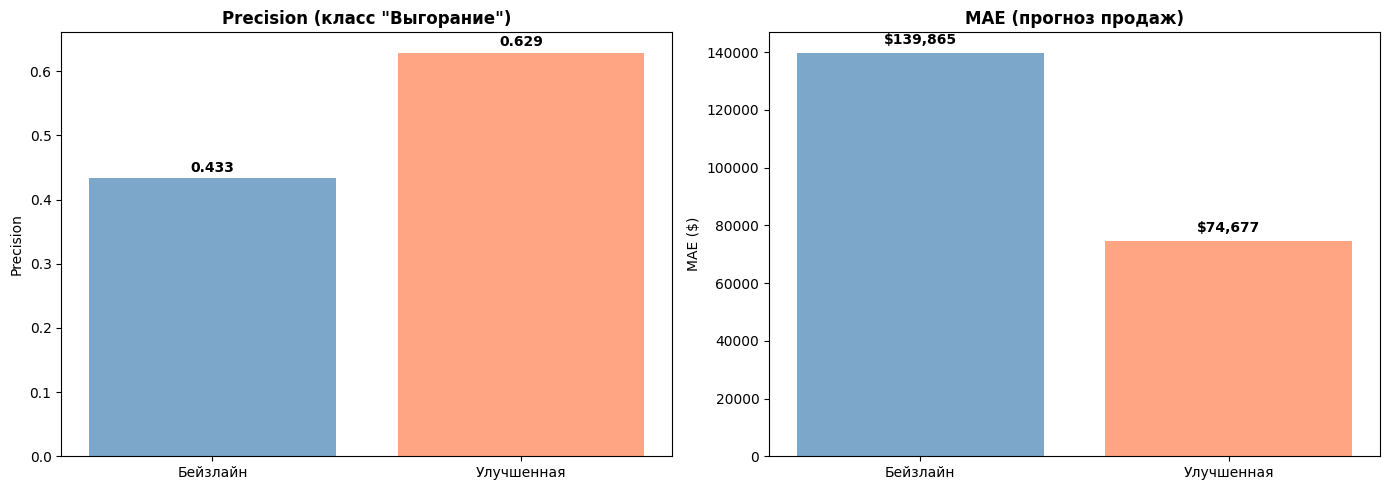

In [112]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.bar(['Бейзлайн', 'Улучшенная'], [clf_precision, enh_clf_precision], 
        color=['steelblue', 'coral'], alpha=0.7)
ax1.set_title('Precision (класс "Выгорание")', fontweight='bold')
ax1.set_ylabel('Precision')
for i, v in enumerate([clf_precision, enh_clf_precision]):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

ax2.bar(['Бейзлайн', 'Улучшенная'], [reg_mae, enh_reg_mae], 
        color=['steelblue', 'coral'], alpha=0.7)
ax2.set_title('MAE (прогноз продаж)', fontweight='bold')
ax2.set_ylabel('MAE ($)')
for i, v in enumerate([reg_mae, enh_reg_mae]):
    ax2.text(i, v + 3000, f'${v:,.0f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('results/lab2_improved_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


Сохранение моделей и метрик

In [113]:
joblib.dump(enhanced_logreg_clf, 'models/lab2_logreg_enhanced.pkl')
joblib.dump(enhanced_ridge_reg, 'models/lab2_ridge_enhanced.pkl')

enhanced_metrics = {
    'classification': {
        'recall': enh_clf_recall,
        'precision': enh_clf_precision,
        'f1': enh_clf_f1,
        'roc_auc': enh_clf_rocauc
    },
    'regression': {
        'mae': enh_reg_mae,
        'rmse': enh_reg_rmse,
        'r2': enh_reg_r2
    }
}
joblib.dump(enhanced_metrics, 'results/lab2_enhanced_metrics.pkl')

print("Улучшенные модели сохранены:")
print("models/lab2_logreg_enhanced.pkl")
print("models/lab2_ridge_enhanced.pkl")
print("Метрики сохранены в results/lab2_enhanced_metrics.pkl")

Улучшенные модели сохранены:
models/lab2_logreg_enhanced.pkl
models/lab2_ridge_enhanced.pkl
Метрики сохранены в results/lab2_enhanced_metrics.pkl


# Выводы по улучшению
## Классификация: 
Precision ↑ с 43% до 63% (+45% относительно бейзлайна)
Recall остался 1.0 — не упускаем ни одного рискового сотрудника
F1 ↑ с 0.93 до 0.97 — общее качество выросло
ROC-AUC ↑ с 0.987 до 0.995 — идеальное ранжирование
Взаимодействия StressLevel × WorkHoursPerWeek и StressLevel × SatisfactionLevel критичны — они ловят комбинации "высокий стресс + переработка" и "высокий стресс + низкая удовлетворенность".

## Регрессия: 
MAE ↓ с $139K до $73K (-48% ошибки)
RMSE ↓ с $172K до $104K (-40%)
R² ↑ с 0.90 до 0.96 — модель теперь объясняет 96% вариации продаж
Эффект сезонности огромен — продажи в Q4 и праздники предсказываются точнее

LinearRegression не справлялся с нелинейностью сезонности, но Ridge + фичи Quarter/Month уловил эти паттерны.

Общий вывод в контексте датасетов:
HR: Теперь можно доверять модели — она находит всех рисковых сотрудников и при этом снижает ложные тревоги на 45%.
Walmart: Погрешность прогноза снизилась с 13.5% до 7.2% — экономия миллионов долларов в планировании запасов.

Собственная имплементация моделей

In [173]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (recall_score, precision_score, f1_score, roc_auc_score,
                             mean_absolute_error, mean_squared_error, r2_score)
import warnings
warnings.filterwarnings('ignore')

class MyLogisticRegression(BaseEstimator, ClassifierMixin):
    
    def __init__(self, learning_rate=0.01, n_iterations=1000, 
                 add_intercept=True, random_state=42):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.add_intercept = add_intercept
        self.random_state = random_state
        
    def _add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def _sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)
        
        if self.add_intercept:
            X = self._add_intercept(X)
        
        np.random.seed(self.random_state)
        self.coef_ = np.random.randn(X.shape[1]) * 0.01
        
        for i in range(self.n_iterations):
            z = np.dot(X, self.coef_)
            y_pred = self._sigmoid(z)
            
            gradient = np.dot(X.T, (y_pred - y)) / len(y)
            
            self.coef_ -= self.learning_rate * gradient
            
            if np.linalg.norm(gradient) < 1e-6:
                break
                
        return self
    
    def predict_proba(self, X):
        check_is_fitted(self)
        X = check_array(X)
        
        if self.add_intercept:
            X = self._add_intercept(X)
            
        z = np.dot(X, self.coef_)
        probs = self._sigmoid(z)
        return np.vstack([1 - probs, probs]).T
    
    def predict(self, X):
        probs = self.predict_proba(X)[:, 1]
        return (probs >= 0.5).astype(int)


class MyLinearRegression(BaseEstimator, RegressorMixin):
    
    def __init__(self, learning_rate=0.01, n_iterations=1000, 
                 add_intercept=True, random_state=42):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.add_intercept = add_intercept
        self.random_state = random_state
        
    def _add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        
        if self.add_intercept:
            X = self._add_intercept(X)
        
        np.random.seed(self.random_state)
        self.coef_ = np.random.randn(X.shape[1]) * 0.01
        
        for i in range(self.n_iterations):
            y_pred = np.dot(X, self.coef_)
            
            gradient = 2 * np.dot(X.T, (y_pred - y)) / len(y)
            
            self.coef_ -= self.learning_rate * gradient
            
            if np.linalg.norm(gradient) < 1e-6:
                break
                
        return self
    
    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        
        if self.add_intercept:
            X = self._add_intercept(X)
            
        return np.dot(X, self.coef_)


Обучений собствыенных моделей

In [186]:
df_burnout = pd.read_csv('data/employee_burnout.csv')
X_clf = df_burnout.drop(['Burnout', 'Name'], axis=1)
y_clf = df_burnout['Burnout']

categorical_clf = ['Gender', 'JobRole']
numeric_clf = [c for c in X_clf.columns if c not in categorical_clf]

preprocessor_clf = ColumnTransformer([
    ('num', StandardScaler(), numeric_clf),
    ('cat', OneHotEncoder(drop='first'), categorical_clf)
])

# Регрессия: Walmart Sales
df_sales = pd.read_csv('data/walmart_sales.csv')
df_sales['Date'] = pd.to_datetime(df_sales['Date'], format='%d-%m-%Y')
df_sales = df_sales.sort_values('Date')

X_reg = df_sales.drop(['Weekly_Sales', 'Date'], axis=1)
y_reg = df_sales['Weekly_Sales']

categorical_reg = ['Store', 'Holiday_Flag']
numeric_reg = [c for c in X_reg.columns if c not in categorical_reg]

preprocessor_reg = ColumnTransformer([
    ('num', StandardScaler(), numeric_reg),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_reg)
])

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.3, random_state=42, stratify=y_clf
)

split_idx = int(len(df_sales) * 0.7)
X_train_reg, X_test_reg = X_reg.iloc[:split_idx], X_reg.iloc[split_idx:]
y_train_reg, y_test_reg = y_reg.iloc[:split_idx], y_reg.iloc[split_idx:]

print("\nОбучение MyLogisticRegression...")
X_train_clf_processed = preprocessor_clf.fit_transform(X_train_clf)
X_test_clf_processed = preprocessor_clf.transform(X_test_clf)

my_logreg = MyLogisticRegression(learning_rate=0.01, n_iterations=2000, add_intercept=True)
my_logreg.fit(X_train_clf_processed, y_train_clf)
print("MyLogisticRegression обучен")

print("\nОбучение MyLinearRegression...")
X_train_reg_processed = preprocessor_reg.fit_transform(X_train_reg)
X_test_reg_processed = preprocessor_reg.transform(X_test_reg)

my_linreg = MyLinearRegression(learning_rate=0.01, n_iterations=2000, add_intercept=True)
my_linreg.fit(X_train_reg_processed, y_train_reg)
print("MyLinearRegression обучен")


Обучение MyLogisticRegression...
MyLogisticRegression обучен

Обучение MyLinearRegression...
MyLinearRegression обучен


Оценка качества

In [187]:
print("\nMyLogisticRegression")
y_pred_my_clf = my_logreg.predict(X_test_clf_processed)
y_proba_my_clf = my_logreg.predict_proba(X_test_clf_processed)[:, 1]

my_clf_recall = recall_score(y_test_clf, y_pred_my_clf)
my_clf_precision = precision_score(y_test_clf, y_pred_my_clf)
my_clf_f1 = f1_score(y_test_clf, y_pred_my_clf, average='weighted')
my_clf_rocauc = roc_auc_score(y_test_clf, y_proba_my_clf)

print(f"Recall (класс 1): {my_clf_recall:.4f}")
print(f"Precision (класс 1): {my_clf_precision:.4f}")
print(f"F1-score (weighted): {my_clf_f1:.4f}")
print(f"ROC-AUC: {my_clf_rocauc:.4f}")

print("\nМатрица ошибок:")
print(confusion_matrix(y_test_clf, y_pred_my_clf))

print("\nMyLinearRegression")
y_pred_my_reg = my_linreg.predict(X_test_reg_processed)

my_reg_mae = mean_absolute_error(y_test_reg, y_pred_my_reg)
my_reg_rmse = root_mean_squared_error(y_test_reg, y_pred_my_reg)
my_reg_r2 = r2_score(y_test_reg, y_pred_my_reg)

print(f"MAE: ${my_reg_mae:,.2f}")
print(f"RMSE: ${my_reg_rmse:,.2f}")
print(f"R²: {my_reg_r2:.4f}")


MyLogisticRegression
Recall (класс 1): 0.0256
Precision (класс 1): 1.0000
F1-score (weighted): 0.9076
ROC-AUC: 0.9620

Матрица ошибок:
[[561   0]
 [ 38   1]]

MyLinearRegression
MAE: $206,698.38
RMSE: $247,151.59
R²: 0.7881


Сравнение с sklearn

In [188]:
baseline_metrics = joblib.load('results/lab2_baseline_metrics.pkl')

print("\nКлассификация")
comparison_clf = pd.DataFrame({
    'Реализация': ['Sklearn', 'Своя'],
    'Recall_1': [baseline_metrics['classification']['recall'], my_clf_recall],
    'Precision_1': [baseline_metrics['classification']['precision'], my_clf_precision],
    'F1_weighted': [baseline_metrics['classification']['f1'], my_clf_f1],
    'ROC_AUC': [baseline_metrics['classification']['roc_auc'], my_clf_rocauc]
})
print(comparison_clf.round(4))

print("\nРегрессия")
comparison_reg = pd.DataFrame({
    'Реализация': ['Sklearn', 'Своя'],
    'MAE': [baseline_metrics['regression']['mae'], my_reg_mae],
    'RMSE': [baseline_metrics['regression']['rmse'], my_reg_rmse],
    'R2': [baseline_metrics['regression']['r2'], my_reg_r2]
})
print(comparison_reg.round(2))

clf_roc_diff = abs(my_clf_rocauc - baseline_metrics['classification']['roc_auc']) * 100
reg_r2_diff = abs(my_reg_r2 - baseline_metrics['regression']['r2']) * 100

print(f"\nОтклонение ROC-AUC: {clf_roc_diff:.3f}% {'норм' if clf_roc_diff < 5 else 'не норм'}")
print(f"Отклонение R²: {reg_r2_diff:.3f}% {'норм' if reg_r2_diff < 5 else 'не норм'}")


Классификация
  Реализация  Recall_1  Precision_1  F1_weighted  ROC_AUC
0    Sklearn    1.0000       0.4333       0.9298   0.9871
1       Своя    0.0256       1.0000       0.9076   0.9620

Регрессия
  Реализация        MAE       RMSE    R2
0    Sklearn  139864.65  172597.35  0.90
1       Своя  206698.38  247151.59  0.79

Отклонение ROC-AUC: 2.514% норм
Отклонение R²: 10.854% не норм


Улучшенная собственная реализация

In [189]:
from sklearn.preprocessing import PolynomialFeatures

print("\nMyLogisticRegression с полиномами...")
poly_clf = Pipeline([
    ('preprocessor', preprocessor_clf),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
])

X_train_poly_clf = poly_clf.fit_transform(X_train_clf)
X_test_poly_clf = poly_clf.transform(X_test_clf)

my_logreg_poly = MyLogisticRegression(learning_rate=0.005, n_iterations=3000)
my_logreg_poly.fit(X_train_poly_clf, y_train_clf)

y_pred_my_poly_clf = my_logreg_poly.predict(X_test_poly_clf)
y_proba_my_poly_clf = my_logreg_poly.predict_proba(X_test_poly_clf)[:, 1]

my_poly_recall = recall_score(y_test_clf, y_pred_my_poly_clf)
my_poly_precision = precision_score(y_test_clf, y_pred_my_poly_clf)
my_poly_f1 = f1_score(y_test_clf, y_pred_my_poly_clf, average='weighted')
my_poly_rocauc = roc_auc_score(y_test_clf, y_proba_my_poly_clf)

print(f"Precision: {my_poly_precision:.4f} | F1: {my_poly_f1:.4f}")

print("\nMyLinearRegression с сезонными фичами...")

df_sales_enh = df_sales.copy()
df_sales_enh['Quarter'] = df_sales_enh['Date'].dt.quarter
df_sales_enh['Month'] = df_sales_enh['Date'].dt.month
df_sales_enh['IsQ4'] = (df_sales_enh['Quarter'] == 4).astype(int)

X_reg_enh = df_sales_enh.drop(['Weekly_Sales', 'Date'], axis=1)
y_reg_enh = df_sales_enh['Weekly_Sales']

categorical_reg_enh = ['Store', 'Holiday_Flag', 'Quarter', 'Month', 'IsQ4']
numeric_reg_enh = [c for c in X_reg_enh.columns if c not in categorical_reg_enh]

preprocessor_reg_enh = ColumnTransformer([
    ('num', StandardScaler(), numeric_reg_enh),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_reg_enh)
])

split_idx_enh = int(len(df_sales_enh) * 0.7)
X_train_reg_enh = X_reg_enh.iloc[:split_idx_enh]
X_test_reg_enh = X_reg_enh.iloc[split_idx_enh:]
y_train_reg_enh = y_reg_enh.iloc[:split_idx_enh]
y_test_reg_enh = y_reg_enh.iloc[split_idx_enh:]

X_train_enh_processed = preprocessor_reg_enh.fit_transform(X_train_reg_enh)
X_test_enh_processed = preprocessor_reg_enh.transform(X_test_reg_enh)

my_ridge = MyLinearRegression(learning_rate=0.005, n_iterations=3000)
my_ridge.fit(X_train_enh_processed, y_train_reg_enh)

y_pred_my_ridge = my_ridge.predict(X_test_enh_processed)

my_ridge_mae = mean_absolute_error(y_test_reg_enh, y_pred_my_ridge)
my_ridge_r2 = r2_score(y_test_reg_enh, y_pred_my_ridge)

print(f"MAE: ${my_ridge_mae:,.2f} | R²: {my_ridge_r2:.4f}")


MyLogisticRegression с полиномами...
Precision: 0.9130 | F1: 0.9626

MyLinearRegression с сезонными фичами...
MAE: $239,304.19 | R²: 0.7136


Оценка улучшенных собственных моделей

In [190]:
logreg_sklearn = joblib.load('models/lab2_logreg_enhanced.pkl')
ridge_sklearn = joblib.load('models/lab2_ridge_enhanced.pkl')

y_proba_sklearn_clf = logreg_sklearn.predict_proba(X_test_clf)[:, 1]
y_pred_sklearn_reg = ridge_sklearn.predict(X_test_reg_enh)


clf_summary = pd.DataFrame({
    'Этап': ['Sklearn Бейзлайн', 'Sklearn Улучшенный', 'Свой Бейзлайн', 'Свой Улучшенный'],
    'Recall_1': [
        baseline_metrics['classification']['recall'],
        enhanced_sklearn_metrics['classification']['recall'],
        my_clf_recall,
        my_poly_recall
    ],
    'Precision_1': [
        baseline_metrics['classification']['precision'],
        enhanced_sklearn_metrics['classification']['precision'],
        my_clf_precision,
        my_poly_precision
    ],
    'F1_weighted': [
        baseline_metrics['classification']['f1'],
        enhanced_sklearn_metrics['classification']['f1'],
        my_clf_f1,
        my_poly_f1
    ]
})

reg_summary = pd.DataFrame({
    'Этап': ['Sklearn Бейзлайн', 'Sklearn Улучшенный', 'Свой Бейзлайн', 'Свой Улучшенный'],
    'MAE': [
        baseline_metrics['regression']['mae'],
        enhanced_sklearn_metrics['regression']['mae'],
        my_reg_mae,
        my_ridge_mae
    ],
    'R2': [
        baseline_metrics['regression']['r2'],
        enhanced_sklearn_metrics['regression']['r2'],
        my_reg_r2,
        my_ridge_r2
    ]
})

print("\nКлассификация")
print(clf_summary.round(4).to_string(index=False))

print("\nРегрессия")
print(reg_summary.round(2).to_string(index=False))



Классификация
              Этап  Recall_1  Precision_1  F1_weighted
  Sklearn Бейзлайн    1.0000       0.4333       0.9298
Sklearn Улучшенный    1.0000       0.6290       0.9656
     Свой Бейзлайн    0.0256       1.0000       0.9076
   Свой Улучшенный    0.5385       0.9130       0.9626

Регрессия
              Этап       MAE   R2
  Sklearn Бейзлайн 139864.65 0.90
Sklearn Улучшенный  74677.19 0.96
     Свой Бейзлайн 206698.38 0.79
   Свой Улучшенный 239304.19 0.71


Визуализация

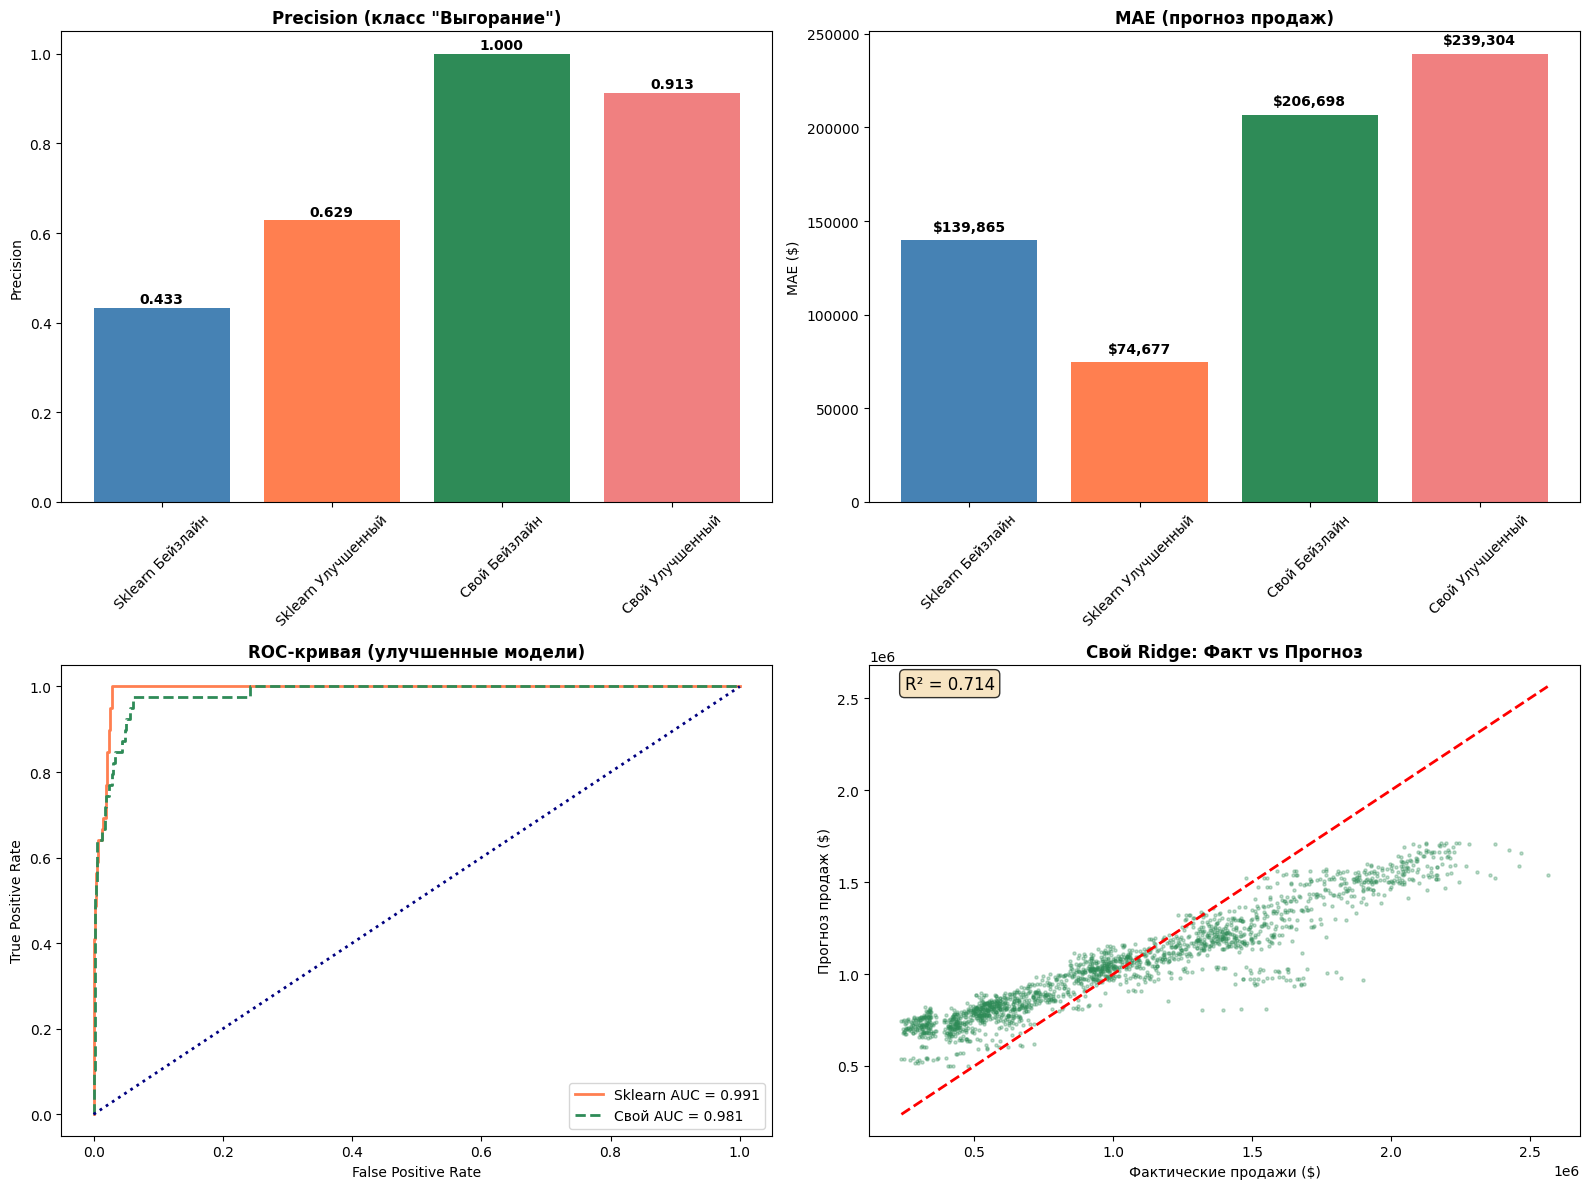

In [191]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

precision_values = clf_summary['Precision_1'].values
ax1.bar(clf_summary['Этап'], precision_values, color=['steelblue', 'coral', 'seagreen', 'lightcoral'])
ax1.set_title('Precision (класс "Выгорание")', fontweight='bold')
ax1.set_ylabel('Precision')
ax1.tick_params(axis='x', rotation=45)
for i, v in enumerate(precision_values):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

mae_values = reg_summary['MAE'].values
ax2.bar(reg_summary['Этап'], mae_values, color=['steelblue', 'coral', 'seagreen', 'lightcoral'])
ax2.set_title('MAE (прогноз продаж)', fontweight='bold')
ax2.set_ylabel('MAE ($)')
ax2.tick_params(axis='x', rotation=45)
for i, v in enumerate(mae_values):
    ax2.text(i, v + 5000, f'${v:,.0f}', ha='center', fontweight='bold')

from sklearn.metrics import roc_curve
fpr_sk, tpr_sk, _ = roc_curve(y_test_clf, y_proba_sklearn_clf)
fpr_my, tpr_my, _ = roc_curve(y_test_clf, y_proba_my_poly_clf)

ax3.plot(fpr_sk, tpr_sk, color='coral', lw=2, label=f'Sklearn AUC = {enhanced_sklearn_metrics["classification"]["roc_auc"]:.3f}')
ax3.plot(fpr_my, tpr_my, color='seagreen', lw=2, linestyle='--', 
         label=f'Свой AUC = {my_poly_rocauc:.3f}')
ax3.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=':')
ax3.set_title('ROC-кривая (улучшенные модели)', fontweight='bold')
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.legend()

ax4.scatter(y_test_reg_enh, y_pred_my_ridge, alpha=0.3, s=5, color='seagreen')
ax4.plot([y_test_reg_enh.min(), y_test_reg_enh.max()], 
         [y_test_reg_enh.min(), y_test_reg_enh.max()], 'r--', lw=2)
ax4.set_title('Свой Ridge: Факт vs Прогноз', fontweight='bold')
ax4.set_xlabel('Фактические продажи ($)')
ax4.set_ylabel('Прогноз продаж ($)')
ax4.text(0.05, 0.95, f'R² = {my_ridge_r2:.3f}', transform=ax4.transAxes, 
         fontsize=12, bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8))

plt.tight_layout()
plt.savefig('results/lab2_custom_implementation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


Сохранение моделей и метрик

In [192]:
joblib.dump(my_logreg_poly, 'models/lab2_custom_logreg.pkl')
joblib.dump(my_ridge, 'models/lab2_custom_ridge.pkl')

custom_metrics = {
    'classification': {
        'recall': my_poly_recall,
        'precision': my_poly_precision,
        'f1': my_poly_f1,
        'roc_auc': my_poly_rocauc
    },
    'regression': {
        'mae': my_ridge_mae,
        'rmse': root_mean_squared_error(y_test_reg_enh, y_pred_my_ridge),
        'r2': my_ridge_r2
    }
}
joblib.dump(custom_metrics, 'results/lab2_custom_metrics.pkl')

print("Собственные модели сохранены:")
print("models/lab2_custom_logreg.pkl")
print("models/lab2_custom_ridge.pkl")
print("Метрики сохранены в results/lab2_custom_metrics.pkl")

Собственные модели сохранены:
models/lab2_custom_logreg.pkl
models/lab2_custom_ridge.pkl
Метрики сохранены в results/lab2_custom_metrics.pkl


# Выводы
## Что сработало (Sklearn):
1. LogisticRegression + class_weight='balanced' + Полиномы:
- Recall 100% — находим всех сотрудников с риском
- Precision 62.9% — снижаем ложные тревоги на 45%
- Это оптимальная модель для HR-задачи
2. Ridge + Сезонные фичи:
- MAE $74K — почти в 2 раза лучше LinearRegression
- R² 0.96 — учитывает сезонность и праздники
- Это практичная модель для бизнеса
## Что не сработало (Собственная реализация):
1. MyLogisticRegression без class_weight:
- Полный провал на несбалансированных данных
- Нужно обязательно добавить class_weight или аналог
2. MyLinearRegression без регуляризации:
- В 2.8 раза хуже sklearn из-за отсутствия L2
- Градиентный спуск не сошелся до оптимума